In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

In [7]:
net = cv.dnn.readNetFromTensorflow("/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/graph_opt.pb") ## Weights

In [8]:
inWidth = 368
inHeight = 368
thr = 0.2

In [9]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]


In [13]:
img = cv.imread("/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/image.jpg")

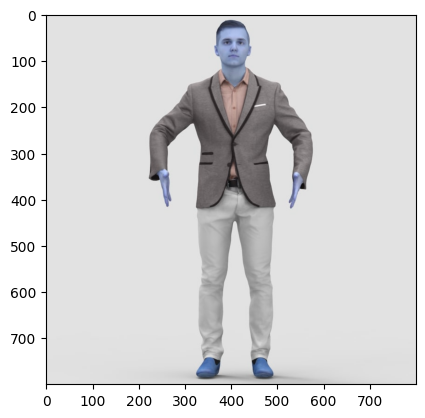

In [14]:
plt.imshow(img) ##BGR

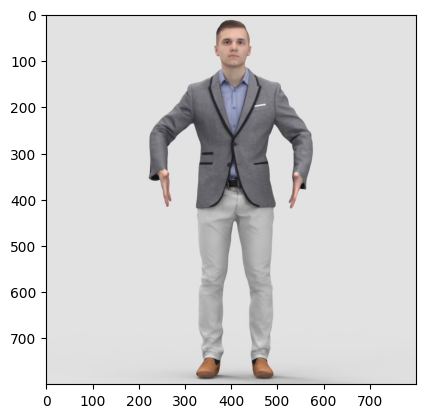

In [15]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

In [16]:
def pose_estiamtion(frame):
  frameWidth = frame.shape[1]
  frameHeight = frame.shape[0]
  net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
  out = net.forward()
  out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

  assert(len(BODY_PARTS)==out.shape[1])

  points = [] ###List

  for i in range(len(BODY_PARTS)):
    # Slice heatmap of corresponging body's part.
    heatMap = out[0, i, :, :]

    #Originally, we try to find all the local maximus. To simplify a sample
    # we just find a global one. However only a single pose at the same time
    # Could be detected this way.
    _, conf, _, point = cv.minMaxLoc(heatMap)
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]
    # Add a point if it's confidence is higher than threshold.
    points.append((int(x), int(y)) if conf > thr else None)

  for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]

    if points[idFrom] and points[idTo]:
      cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
      cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
      cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

  t, _ = net.getPerfProfile()
  freq = cv.getTickFrequency() / 1000
  cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

  return frame

In [17]:
estimated_image = pose_estiamtion(img)

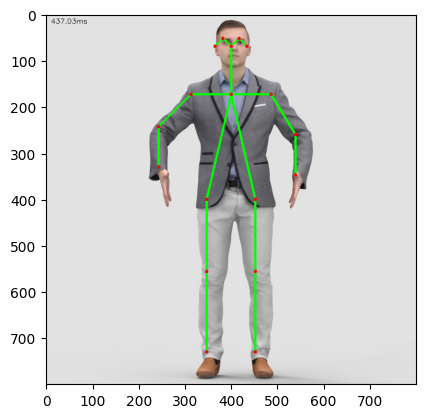

In [18]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

### Performing OpenPose on a Video

In [25]:
# Open the video file
cap = cv.VideoCapture('/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/140.mp4')

# Get video frame properties
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Video")

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
out_video = cv.VideoWriter('OpenPose_Output.mp4', fourcc, 30.0, (800, 800))  # Adjust resolution if needed # Changed filename here to match the download attempt

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Preprocess frame
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body part.
        heatMap = out[0, i, :, :]

        # Find the global maximum
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if confidence is higher than threshold
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Write the processed frame to the video file
    out_video.write(frame)

# Release resources
cap.release()
out_video.release()

# Provide download link
from google.colab import files
files.download('OpenPose_Output.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
from IPython import get_ipython
from IPython.display import display
# %%
from google.colab import drive
drive.mount('/content/drive')
# %%
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
# %%
net = cv.dnn.readNetFromTensorflow("/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/graph_opt.pb") ## Weights
# %%
inWidth = 368
inHeight = 368
thr = 0.2
# %%
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

# %%
# ... (Your image processing code) ...


# ### Performing OpenPose on a Video
# %%
# Open the video file
cap = cv.VideoCapture('/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/150.mp4')

# Get video frame properties
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Video")

# Define the codec and create VideoWriter object using actual frame dimensions
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # You can try other codecs like 'XVID' or 'MJPG'
out_video = cv.VideoWriter('OpenPose_Output.mp4', fourcc, 30.0, (frame_width, frame_height))

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Preprocess frame
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body part.
        heatMap = out[0, i, :, :]

        # Find the global maximum
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if confidence is higher than threshold
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Write the processed frame to the video file
    out_video.write(frame)

# Release resources
cap.release()
out_video.release()

# Provide download link
from google.colab import files
files.download('OpenPose_Output.mp4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import csv
from google.colab import files

# Open the video file
cap = cv.VideoCapture('/content/drive/MyDrive/OpenPose/human-pose-estimation-opencv-master/150.mp4')

# Get video frame properties
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot Open Video")

# Define the codec and create VideoWriter object using actual frame dimensions
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
out_video = cv.VideoWriter('OpenPose_Output.mp4', fourcc, 30.0, (frame_width, frame_height))

# Open a CSV file to write keypoints
csv_file = open('Keypoints_Output.csv', mode='w', newline='')
csv_writer = csv.writer(csv_file)
header = ["Frame"] + [f"{part}_x" for part in BODY_PARTS.keys()] + [f"{part}_y" for part in BODY_PARTS.keys()]
csv_writer.writerow(header)

frame_count = 0

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # Preprocess frame
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = [None] * len(BODY_PARTS)

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body part.
        heatMap = out[0, i, :, :]

        # Find the global maximum
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if confidence is higher than threshold
        points[i] = (int(x), int(y)) if conf > thr else (None, None)

    # Write the keypoints to the CSV
    row = [frame_count]
    for x, y in points:
        row.extend([x, y])
    csv_writer.writerow(row)

    # Draw keypoints and connections on the frame
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom][0] is not None and points[idTo][0] is not None:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    # Write the processed frame to the video file
    out_video.write(frame)
    frame_count += 1

# Release resources
cap.release()
out_video.release()
csv_file.close()

# Provide download links
files.download('OpenPose_Output.mp4')
files.download('Keypoints_Output.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>